#  **Trabalho 1 - Esteganografia**

### **Objetivo:**
O trabalho a seguir tem por objetivo, desenvolver e exercitar os conceitos de manipulação de vetores multidimensionais, bem como incentivar a exploração de bibliotecas amplamente utilizadas em processamentos de dados, statistical learning, plotagem de gráficos e manipulação de imagens.

### **Discussão:**

Através desse notebook, serão discutidas pontualmente as descobertas e dificuldades encontradas no processo de criação de um algoritmo de  **esteganografia**. Aproveitando-se da modularização que o jupyter notebook permite, passaremos por todos os passos que levam ao sucesso do algoritmo, discorrendo sobre pontos importantes, revisitando a linha de pensamento utilizada para a solução dos pequenos problemas do procedimento e demonstrando interativamente todos os módulos e processos do programa completo.

## **Introdução:**

### **A esteganografia**
> O processo de **esteganografia** faz referência ao conjunto de técnicas utilizadas para a ocultação de informações dentro de imagens. Uma técnica comum e a que será utilizada no decorrer desse projeto, é a de esconder mensagens textuais em uma imagem, através da modificação dos bits menos significativos dos pixels de uma imagem, para codificar os caracteres que compõe o texto a ser ocultado sem alterar de forma notável a aparência da imagem. Tendo isso em mente, implementaremos essa técnica, afim de ocultar uma mensagem contida em um arquivo de texto em uma imagem colorida a nossa escolha.

### **Representação de imagens coloridas**

> Para que isso seja possível, precisamos entender como imagens coloridas, especificamente imagens RGB, são representadas na memória. Podemos entender imagens em escala de cinza como matrizes de pixels, em que cada pixel recebe um valor numérico de 0 a 255 que representa o nível da escala de cinza (do inglês GSL), dessa forma uma imagem 512x512px pode ser representada por uma matriz bidimensional [512,512] preenchida com inteiros entre 0 e 255. A lógica por trás de uma imagem colorida no padrão RGB, é a mesma, à diferença de que agora a imagem contém 3 filtros de cor (vermelho, verde e azul), onde, analogamente a imagem em escala de cinza, cada pixel recebe a intensidade da cor da banda correspondente. Assim, a imagem colorida é representada por uma matriz tridimensional onde a dimensão adicionada representa a quantidade de bandas de cor que definem a coloração da imagem. Portanto uma imagem das mesmas dimensões anteriores, no formato RGB agora é representada por uma matriz tridimensional [512,512,3] de inteiros.

### **Representação binária de inteiros**

> Outro conceito importante para a aplicação da técnica é o de representação de inteiros e caracteres como números binários. Basicamente, um número inteiro na base 10 pode ser convertido em um número binário (base 2) tendo seu valor representado apenas com os dígitos 0 ou 1. Especificamente para o caso do processamento de imagens em que os inteiros estão delimitados ao intervalo entre 0 e 255, todos as possibilidades de valores podem ser escritas como binários de 8 dígitos e o intervalo passa a ser [0b00000000, 0b11111111].

### **Representação binária de caracteres**

> Da mesma forma, caracteres são convertidos em códigos para serem entendidos pela máquina, a condificação que utilizaremos é o UTF-8 que é completamente compatível com a famosa tabela ASCII, incluindo sua versão extendida, em que convenientemente todos os caracteres podem ser representados por binários de 8 bits (256 possíveis códigos).

### **Ocultando a mensagem**

> Essa convergência de representação, nos permitirá codificar a mensagem em uma sequência de 0s e 1s que poderá ser substituída nos bits menos significativos de cada um dos pixels da imagem. Como convenção para o projeto, substituiremos sequencialmente os bits da mensagem no dígito menos significativo de cada pixel da imagem e se as três bandas de bits não forem suficientes, passaremos para o segundo bit menos significativo, fazendo o mesmo para o terceiro se necessário.


## **O código**

> Após a breve retomada de conceitos, podemos botar a mão na massa e partir para o código onde gradativamente os conceitos serão revisitados e explicados em mais detalhes.

**Bibliotecas:**

As bibliotecas utilizadas para o programa serão a **OpenCV** para lidar com as imagens utilizadas; **matplotlib** para plotar as imagens intermediárias geradas; e talvez a mais importante, NumPy, para o tratamento das matrizes utilizadas. Uma última biblioteca foi importada para o display da imagem completa.  

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

**Arquivos de entrada:**

As imagens e arquivos de texto necessários para a execução do programa podem ser encontrados [nesse link](https://drive.google.com/drive/folders/19YaZpY3yCwiaEn8Q7a8Pg_KhEKf6aKM7?usp=sharing) e foram enviados como uma pasta "data" da qual os arquivos devem ser upados diretamente no diretório do notebook.

Primeiramente lemos a imagem RGB do arquivo que pode ser vista abaixo.

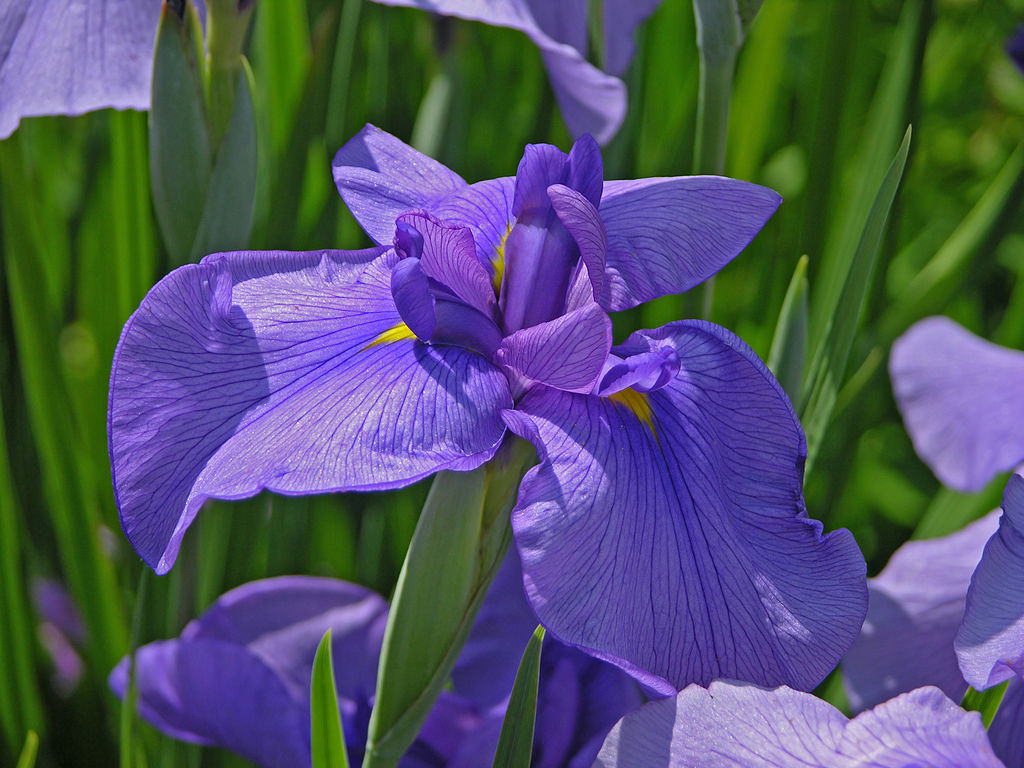

In [59]:
img = cv2.imread('iris1.jpg')
Image(filename = 'output.png', width=500)

Em seguida a transformamos em um numpy array com dimensões ```[height, width, 3]```.

In [62]:
img = np.array(img)   #transforma matriz em um vetor numpy
print(img.shape)      #imprime as dimensões da matriz

(768, 1024, 3)


Podemos agora definir uma função que se encarregará de imprimir os 3 filtros de cor separadamente com ajuda da matplotlib.

In [66]:
def plot_color_bands(img):
  np.set_printoptions(threshold=np.inf)
  plt.subplot(1,3,1)
  plt.imshow(img[:,:,0], cmap= 'Blues' )
  plt.axis('off')
  plt.title('Banda azul')
  plt.subplot(1,3,2)
  plt.imshow(img[:,:,1], cmap= 'Greens')
  plt.axis('off')
  plt.title('Banda verde')
  plt.subplot(1,3,3)
  plt.imshow(img[:,:,2], cmap= 'Reds')
  plt.axis('off')
  plt.title('Banda vermelha')
  plt.show()

Através do plot podemos perceber a diferença das intensidades de pixels correspondentes em diferentes bandas. Outro fato curioso, é que apesar do nome RGB, na representação matricial a primeira banda que é convertida (índice ```[:,:,0]```) é a banda azul e a última a vermelha, contrariando o que o nome sugere.

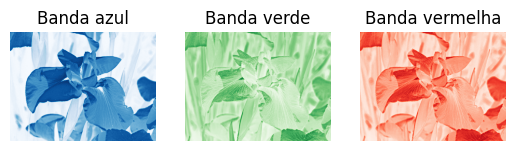

In [67]:
plot_color_bands(img)

O próximo passo a ser feito, seria estudar o quanto as imagens são dependentes dos dígitos menos significativos de suas intensidades. Para tanto, entenderemos cada banda de cor como uma matriz tridimensional ```[height, width, bit index]``` onde cada banda agora pode ser subplotada como 8 matrizes de 1s e 0s de cada um dos bits dos números inteiros que representam a intensidade de cada cor.
[IMAGEM]

Para que as dimensões da matriz original não fossem alteradas, a saída encontrada foi criar a função bit_matrix que utiliza o operador bit-a-bit **AND** com uma máscara binária com apenas o dígito de interesse ativado. Conhecendo o básico de operadores e máscaras binárias é possível compreender que o resultado dessa operação é o dígito correspondente ao bit ativo da máscara no número comparado. Assim se fizermos a operação, por exemplo, ```0b01010101 AND 0b01000000``` teremos como resultado o binário 0 ```b01000000```, que pode ser normalizado na base decimal dividindo esse número pelo valor decimal correspondente do bit ativo da mascara. O interessante é que mesmo operando sobre decimais o resultado vale, por se tratarem de operadores bit-a-bit.

In [69]:
def bin_matrix(img, mask):
  maskd_img = np.empty_like(img)          #cria um numpy array vazio do mesmo formato da imagem
  maskd_img[:,:,:] = img[:,:,:] & (mask)  #aplica a máscara para tomar apenas o bit mais significativo
  maskd_img = maskd_img/mask              #divide pelo valor correspondente ao setimo bit
  maskd_img = maskd_img.astype(int)       #transforma os valores de float (após a divisão acima) para int
  return maskd_img                        #retorna a matriz binária

Aplicamos agora nossa nova função na imagem de entrada para os bits de interesse 7 (mais significativo), do qual espera-se que a imagem inicial tenha uma maior dependência; e 0, 1 e 2 (menos significativos) dos quais espera-se uma menor dependência.

In [ ]:
img_7 = bin_matrix(img, 0b10000000)
img_0 = bin_matrix(img, 0b00000001)
img_1 = bin_matrix(img, 0b00000010)
img_2 = bin_matrix(img, 0b00000100)

Plotando agora as bandas de cor das imagens de cada um dos bits de interesse, vemos que alterar um bit na matriz de bits mais significativos (índice 7) seria uma péssima idéia, pois haveria uma significativa mudança nos padrões da imagem, o que acarretaria em um extremo ruído após a esteganografia. Sobre as matrizes de bits menos significativos, vemos que as imagens resultantes carregam pouquíssima informação e a partir do bit 2 começam a se assemelhar de maneira sutil a imagem original, dessa forma é seguro afirmar que o ruído gerado ao alterar esses bits seria imperceptível ou quase imperceptível aos olhos humanos.

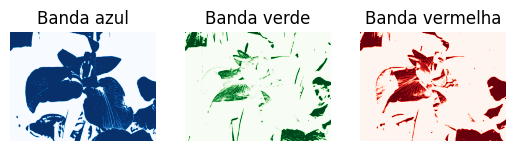

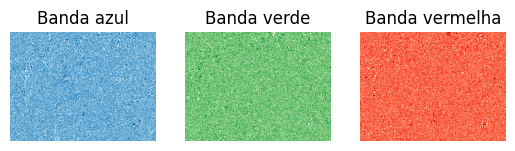

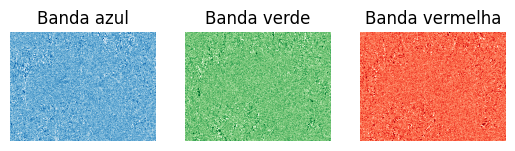

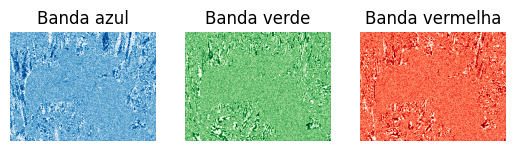

In [71]:
plot_color_bands(img_7)
plot_color_bands(img_0)
plot_color_bands(img_1)
plot_color_bands(img_2)

Feita a análise da imagem RGB e as funções necessárias para a sua manipulação passaremos agora para o tratamento do texto a ser ocultado, onde a função abaixo lê a string do arquivo de texto, converte a string para um vetor de bits sequenciais que representam, 8-a-8, os caracteres da mensagem do arquivo texto e adiciona o caractere @ (64 extended-ASCII)ao final para que futuramente o decodificador saiba quando a mensagem termina.

In [78]:
def txt_to_bin(path):
  with open(path,'r', encoding = 'utf-8') as file:
      content = file.read()
  msg = np.array(list(content))
  msg = [ord(char) for char in msg]
  bin_msg =[bin(num)[2:].zfill(8) for num in msg]
  bin_msg = np.append(bin_msg,'01000000')
  bit_array = np.array(list(''.join(bin_msg))).astype(int)
  return bit_array

Aplicamos a função ao arquivo texto de entrada.

In [ ]:
bit_array = txt_to_bin('input.txt')
print (bit_array)

E podemos enfim ocultar a mensagem dentro da imagem. Através de operações vetorizadas.

In [83]:
def coder(img):
  height = img[:,0,0].size
  width = img[0,:,0].size
  img_out = np.reshape(img,(img.size,))
  img_out[0:bit_array.size] = np.where(bit_array[:] == 0, img_out[0:bit_array.size] & 0b11111110, img_out[0:bit_array.size] | 0b00000001)
  img_out = np.reshape(img,(height,width,3))
  cv2.imwrite('output.png', img_out)


Como apenas o bit menos significativo dos pixels necessários foi alterado não se vê diferença entre a foto de entrada e de saída.

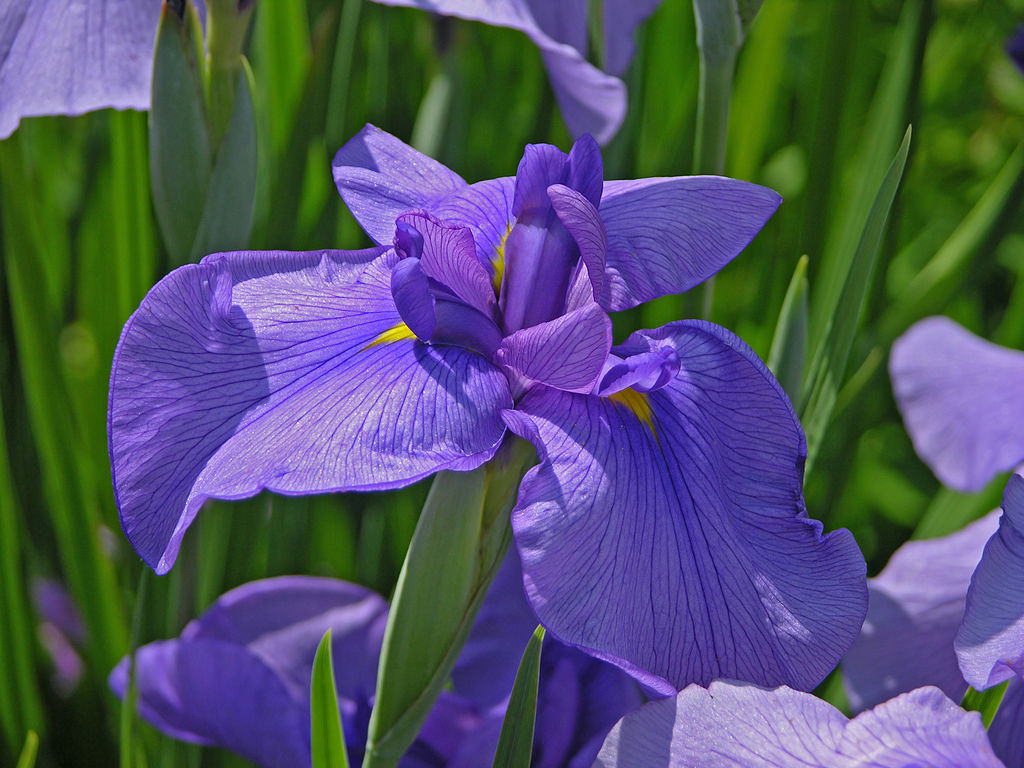

In [84]:
Image(filename = 'output.png', width=500)

Na função abaixo transformamos o vetor de binários em uma string que possa ser escrita no arquivo texto, utilizando estratégias análogas a descritas anteriormente.

In [86]:
def bin_to_str(array):
  at = np.zeros(8)
  at[1] = 1
  bin_array = np.empty(0).astype(str)
  bin_out = np.empty(0).astype(str)
  for i in range(8,array.size,8):
    bin_array = np.append(bin_array, array[i-8:i])
    bin_out = np.append(bin_out, ''.join(list(bin_array)))
    bin_array = np.empty(0).astype(str)
    if np.allclose(array[i-8:i], at):
      break
  out = np.array([chr(int(bin,2)) for bin in bin_out[0:bin_out.size-1]])
  out = ''.join(list(out))
  return out

Enfim a função de decodificação que printa no terminal a mensagem decodificada e escreve ela em um arquivo de saída.

In [94]:
def decoder(path):
  img = cv2.imread(path)
  img = np.array(img)
  img = np.reshape(img, (img.size,))
  img[0:img.size] = img[0:img.size] & 0b00000001
  output = bin_to_str(img)
  print(output)
  with open('output.txt','w') as file:
    file.write(output)

In [93]:
decoder('output.png')

Tem mulher que não depende de homem, problema delas
Um brinde às que depende, subo o voucher, boto nelas
Essa é minha vida, tem várias amiga
Que não liga de ganhar um presentin'
Eu de Palm Angels, ela Yves Saint Laurent
Toda delicada, com salto da Louboutin
O da maçã, no Instagram lancei o 15
Crise? Eu nem conheço essa palavra
Junta aquelas boa com as boa que eu trouxe
Tipo passarela, essa é nossa revoada
Porsche, Meca, Fefa, não se esqueça
Humildade vem primeiro
Hoje o comboio de Lacoste, de esportivo
Mina já se perde na chave dos maloqueiro
Preto tatuado, 01 dos fatos
Que foram os relatados no beat do GBR
Ela me chama de Igor Guilherme
Meu nome não é Igor
Tu tá tonta ou tá com febre?
Um salve, as saudações pro mano Kevin, ah
Let's go, baby
Let's go, baby
Não queria antes, quando a vida não andava
Relacionamento não se encontra por aqui
Let's go, baby
Let's go, baby
Não queria antes, quando a vida não andava
Relacionamento não se encontra por aqui
Coração fechado e fechado tá minha ca